# ResNet performace on ROOMS data set

In [1]:
import json
import numpy as np
import string
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt
import io
import requests
import torchvision
import torchvision.transforms as T
from torch.optim import lr_scheduler
from torchvision import models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os
import random
from sklearn.model_selection import train_test_split
import torch.utils
from torch.utils import data
import torch
import time
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter1d

In [40]:
import progressbar
import math

In [3]:
#Get the data from JSON file
data = []
with open('rooms1.json') as f:
    for line in f:
        data.append(json.loads(line))

In [13]:
#Create a folder with JPEG images from the URLs
#folderName = 'd:/Users/Home/Desktop/Open-U/Rooms_classification/image_data/rooms/'
#for i in range(DATA_SIZE):
  #  if ((data[i]['annotation']['labels']!=[])and (data[i]['content']!='')):
     #   img=Image.open(requests.get(data[i]['content'], stream=True).raw)
     #   img.save(folderName+str(i)+".jpg") 

In [4]:
#Create dictionary with image URLs and labels and create arrays with labels and images
dictnr={}
labels_var=[]
images=[] 
for i in range(len(data)):
    if ((data[i]['annotation']['labels']!=[])and (data[i]['content']!='')):
            dictnr[data[i]['content']] = data[i]['annotation']['labels'][0]
            labels_var.append(data[i]['annotation']['labels'][0])
            jpgfile = Image.open("d:/Users/Home/Desktop/Open-U/Rooms_classification/image_data/rooms/"+str(i)+".jpg")
            img = jpgfile .convert('RGB')
            images.append(img)

In [5]:
#Print all the unique labels
dictnr_values=dictnr.values()
rooms_class=list(set(dictnr.values()))
print('List of the labels for rooms:',rooms_class)

List of the labels for rooms: ['kitchen', 'bathroom', 'bedroom', 'exterior', 'other', 'livingroom']


There are 6 classes

In [6]:
#get the place(index) of class in room_class list
def get_label(i):
    return rooms_class[i]

In [7]:
# Create list with indexes of labels corresponding to images im images list
labels=[]
for i in range(len(labels_var)):
    labels.append(rooms_class.index(labels_var[i]))

In [8]:
#get corresponding label for list containing indexes
def get_labels_for_list(labels):
    labels_class=[]
    for i in range(len(labels)):  
        labels_class.append(get_label(int(labels[i])))  
    return labels_class    

In [9]:
DATA_SIZE=len(labels)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [11]:
# generate  train test and validation data sets

In [12]:
train_images=np.zeros(shape=(1,))
train_labels=np.zeros(shape=(1,))

validation_images=np.zeros(shape=(1,))
validation_labels=np.zeros(shape=(1,))

test_images=np.zeros(shape=(1,))
test_labels=np.zeros(shape=(1,))

temp_images=np.zeros(shape=(1,))
temp_labels=np.zeros(shape=(1,))

In [13]:
#Form train,test,validation sets
temp_images,test_images, temp_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)
train_images,validation_images, train_labels, validation_labels = train_test_split(temp_images, temp_labels, test_size=0.1, random_state=42)

In [14]:
print('train set size:',len(train_images),', validation set size:',len(validation_images),', test set size:',len(test_images))

train set size: 6045 , validation set size: 672 , test set size: 3309


In [ ]:
#Create data set

In [15]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)        
        return x, y    
    def __len__(self):
        return len(self.data)

In [16]:
#Define transformations for image

In [16]:
normalize = T.Normalize(
   mean=MEAN,
   std=STD
)
data_transforms = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   normalize
])

In [17]:
train_dataset = MyDataset(train_images , train_labels ,data_transforms)
validation_dataset = MyDataset(validation_images , validation_labels,data_transforms)
test_dataset = MyDataset(test_images , test_labels,data_transforms)

In [18]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=20,        
        shuffle=True) 
validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=20,        
        shuffle=True) 
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=20,        
        shuffle=True) 

In [19]:
def show_images(images,de_norm=False):    
    fig=plt.figure(figsize=(25,50))
    gs=gridspec.GridSpec(20,10)
    gs.update(wspace=0.01,hspace=0.01)
    for i,img in enumerate(images):      
        ax=plt.subplot(gs[i])
        plt.axis('off')        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal') 
        img=np.asarray(img)
        inp = img.transpose((1, 2, 0))
        if de_norm:
            mean = np.array(MEAN)
            std = np.array(STD)
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
    plt.show()
    return

In [21]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

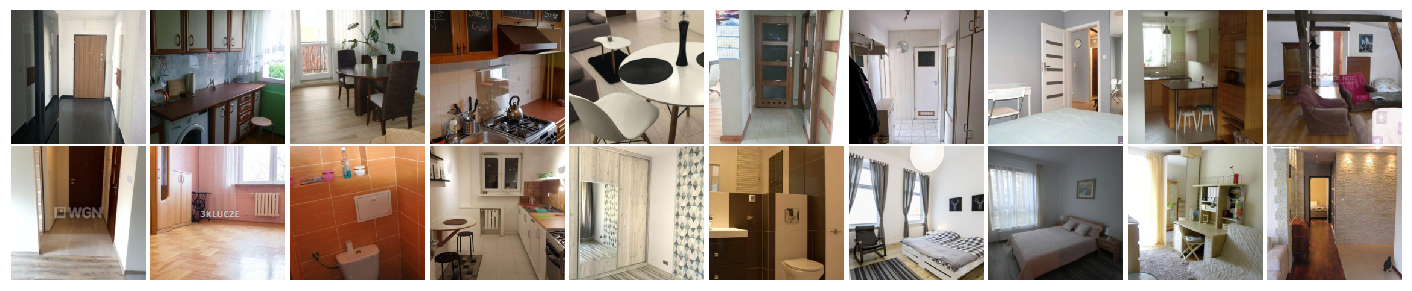

In [21]:
show_images(images,True)

In [ ]:
#Let us first make a try with a pretrained resnet

In [26]:
torch.cuda.empty_cache()

In [27]:
#Let us use the pretrained resnet
model = models.resnet18(pretrained=True)

# freezing all model parameters is required
for param in model.parameters():
    param.requires_grad = False

# Change the last fully-connected layer to recognize our 6 classes 
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 6)
#Learning process definition    
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #, betas=(0.5, 0.999))
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.cuda()

In [28]:
dtype = torch.cuda.FloatTensor

Let us train our network

In [136]:
epochs = 2

In [ ]:
def run_model(model):
    loss_hist_train={}
    loss_hist_validation={}
    for epoch in range(epochs):
        running_loss = 0.0    
        for phase in ('train', 'validation'):
            if phase == 'train':
                loader=train_loader
                scheduler.step()
                model.train(True)
            else:
                loader=validation_loader
                model.train(False)  
            i=0    
            end = time.time()
            bar = progressbar.ProgressBar()
            for data in bar(loader):
                inputs, labels = data   
                inputs =  inputs.type(dtype) 
                labels = labels.type(torch.cuda.LongTensor ) 
            
                optimizer.zero_grad()
            
                #forward
                outputs = model(inputs)
                outputs=outputs.type(dtype)
                loss = criterion(outputs, labels)
            
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item()    
                elapsed_time = time.time() - end
                if i % 10 == 9: 
                    if phase == 'train':
                        loss_hist_train[i+(epoch*len(train_loader))+1] = running_loss/ 10 
                    if phase == 'validation':
                        loss_hist_validation[i+(epoch*len(validation_loader))+1] = running_loss/ 10   
                    running_loss = 0.0
                i=i+1
    return loss_hist_train,loss_hist_validation  

In [30]:
loss_hist_train,loss_hist_validation =run_model(model)

100% (303 of 303) |######################| Elapsed Time: 0:03:40 Time:  0:03:40
100% (34 of 34) |########################| Elapsed Time: 0:00:42 Time:  0:00:42
100% (303 of 303) |######################| Elapsed Time: 0:00:51 Time:  0:00:51
100% (34 of 34) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Text(0,0.5,'loss')

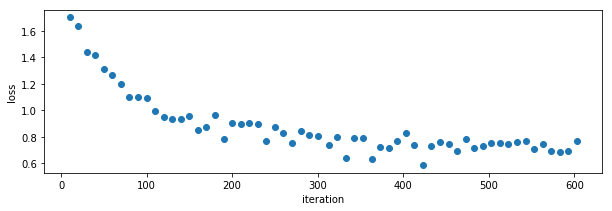

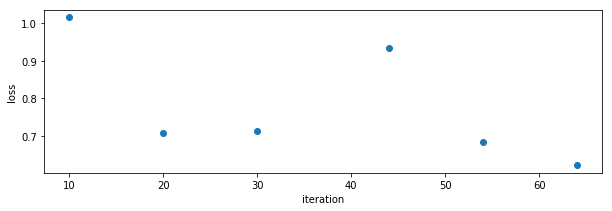

In [31]:
#Train loss
plt.figure(figsize=(10,3))
plt.plot(loss_hist_train.keys(),loss_hist_train.values(), 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
#Validation loss
plt.figure(figsize=(10,3))
plt.plot(loss_hist_validation.keys(),loss_hist_validation.values(), 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

In [ ]:
#what we can notice is that one training epoch is enough for this model

In [ ]:
#Let us see compare the predicted labels with the actual ones for 1 mini batch

In [32]:
model.eval()
inputs, labels = next(iter(test_loader))
inputs =  inputs.type(dtype)   
labels = labels.type(dtype) 

outputs = model(inputs)
_, predicted = torch.max(outputs, 1)

In [33]:
#Let us compare the preformance of our network on a 1 mini-batch
actual=get_labels_for_list(labels)
predicted=get_labels_for_list(predicted)
for i in range(len(actual)):
    print('actual label:',actual[i]+'   ', 'predicted:',predicted[i])

actual label: livingroom    predicted: kitchen
actual label: bedroom    predicted: bedroom
actual label: livingroom    predicted: bedroom
actual label: other    predicted: other
actual label: bathroom    predicted: kitchen
actual label: kitchen    predicted: livingroom
actual label: other    predicted: other
actual label: livingroom    predicted: bedroom
actual label: livingroom    predicted: livingroom
actual label: other    predicted: other
actual label: kitchen    predicted: other
actual label: other    predicted: other
actual label: kitchen    predicted: kitchen
actual label: kitchen    predicted: kitchen
actual label: livingroom    predicted: kitchen
actual label: livingroom    predicted: kitchen
actual label: kitchen    predicted: kitchen
actual label: bedroom    predicted: bedroom
actual label: kitchen    predicted: bathroom
actual label: bedroom    predicted: kitchen


In [34]:
#Let us evaluate the accuracy of our model on the test set
def calculate_accuracy():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images =  images.type(dtype)   
            labels = labels.type(torch.cuda.LongTensor) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 3300 test images: %d %%' % (100 * correct / total))

In [35]:
#Let us calculate the accuracy of our pretrained resnet model on the entire test set
calculate_accuracy()  

Accuracy of the network on the 3300 test images: 74 %


In [139]:
torch.cuda.empty_cache()

In [140]:
#let us try to train a model from scratch

In [145]:
def initialize_weights(m):
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
              #  n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                torch.nn.init.xavier_uniform_(m.weight.data)
        elif isinstance(m, torch.nn.BatchNorm2d) :
                m.weight.data.fill_(1)
                m.bias.data.zero_()    

In [146]:
#Let us use the not pretrained resnet, we will keep the structure but will initialize 
model = models.resnet18(pretrained=False)
for param in model.parameters():
    param.requires_grad = True

# Change the fully-connected layer to recognize the 6 classes 
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 6)
#Learning process    
criterion = torch.nn.CrossEntropyLoss().cuda() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.92)
scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
model = model.cuda()
model.apply(initialize_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [147]:
loss_hist_train,loss_hist_validation =run_model(model)

100% (303 of 303) |######################| Elapsed Time: 0:01:59 Time:  0:01:59
100% (34 of 34) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (303 of 303) |######################| Elapsed Time: 0:01:05 Time:  0:01:05
100% (34 of 34) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Text(0,0.5,'loss')

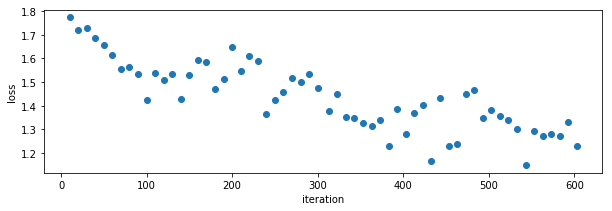

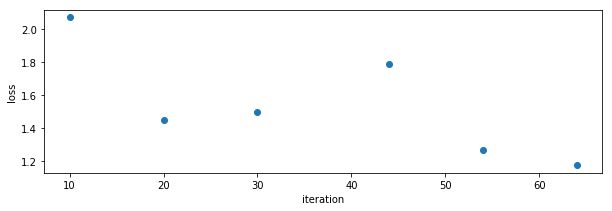

In [148]:
plt.figure(figsize=(10,3))
plt.plot(loss_hist_train.keys(),loss_hist_train.values(), 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.figure(figsize=(10,3))
plt.plot(loss_hist_validation.keys(),loss_hist_validation.values(), 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

In [149]:
calculate_accuracy()  

Accuracy of the network on the 3300 test images: 49 %


Thought the low accuracy let us try to see what the net has learned.
We would like to generate an image to maximize the score of target_y under a pretrained model.
This will help us to understand the kind of information the net will look for to classify the image.

In [ ]:
#Some helper functions

In [150]:
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [151]:
def jitter(X, ox, oy):
#    Helper function to randomly jitter an image.
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [152]:
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=np.divide(1,STD).tolist()),
        T.Normalize(mean=(np.multiply(-1,MEAN).tolist()), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

In [153]:
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [154]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-4)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 600)
    blur_every = kwargs.pop('blur_every', 5)
    max_jitter = kwargs.pop('max_jitter', 10)
    show_every = kwargs.pop('show_every', 600)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        
        scores = model(img)
        
        target_score = scores[0, target_y]
        
        target_score.backward()
        
        # L2 regularization
        grad = img.grad.data
        grad -= 2 * l2_reg * img.data
        
        img.data += learning_rate * (grad / grad.norm())
        
        img.grad.zero_()
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-MEAN[c] /STD[c])
            hi = float((1.0 - MEAN[c]) / STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = rooms_class[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

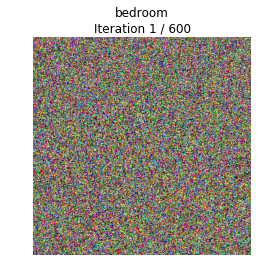

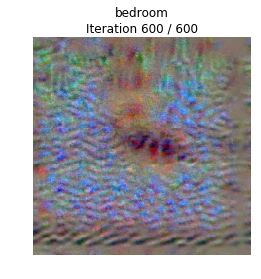

In [155]:
dtype = torch.cuda.FloatTensor 
model.cuda()
target_y = 2 # Bedroom
out = create_class_visualization(target_y, model, dtype)

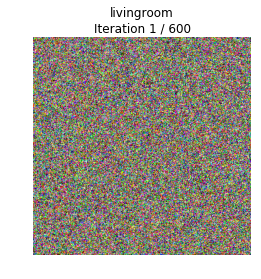

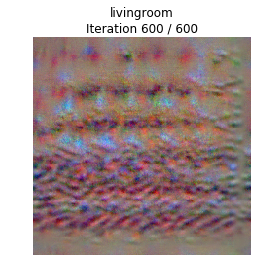

In [156]:
target_y = 5 #Livingroom
out = create_class_visualization(target_y, model, dtype)

As based on these 2 examples we can conclude that the main features/information by which the net will identify the belonging
of the image to any of the above 2 classes are concentrated in different parts of image. Also the color information for each of them is quite different as well. Due to low accuracy (though better than a random guess) no clear structures are visibile.